In [1]:
import pandas as pd
import warnings
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
import math

In [3]:
from sklearn.model_selection import train_test_split 

dataset = pd.read_excel('All_data.xlsx')

X_cols, y_col = ['T2LM (ms)', 'T (K)', 'TE (ms)'], 'Eta (cP)'
X, y = dataset[X_cols],  dataset[y_col]

def engineering(df):
    df['feature_0'] = np.log(df['T2LM (ms)'])
    #df['feature_1'] = 1. / (df['TE (ms)'] * df['T2LM (ms)'])
    df['feature_2'] = np.log(df['T (K)']) / df['TE (ms)']
    df['feature_3'] = np.log(df['T2LM (ms)']) / df['TE (ms)']
    #df['feature_4'] = np.log(df['TE (ms)']) / df['TE (ms)']
    df['feature_5'] = np.log(df['T (K)'])
    #df['feature_6'] = np.log(df['T (K)'])
    return df

#X = engineering(X) # comment this to disable feature engineering 
#Z_col = ['T2LM (ms)', 'T (K)','feature_0','feature_2','feature_3','feature_5']
#Z = X[Z_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) #X PROMENI u Z
                                                    #Z ovdi
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(211, 3) (211,)
(71, 3) (71,)


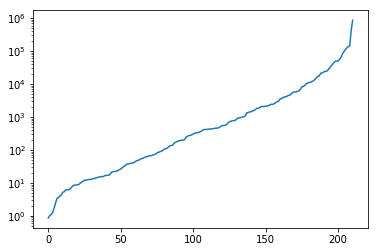

In [4]:
plt.yscale('log')
plt.plot(sorted(y_train))

# try to predict log(Eta (cP))
y_train = np.log(y_train)
y_test = np.log(y_test)
# regular (without log)
#y_train = np.array(y_train).reshape(-1, 1)
#y_test = np.array(y_test).reshape(-1, 1)

In [5]:
from sklearn.metrics import mean_squared_log_error

def plot_results(model):
    # predict logarithms
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # back to Eta (cP)
    y_pred_train = np.exp(y_pred_train)
    y_pred = np.exp(y_pred)
    
    y_true_train = np.exp(y_train)
    y_true = np.exp(y_test)
    
    # plot
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(y_true_train, y_pred_train)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('TRAIN Prediction. MSLE=%f' %  mean_squared_log_error(y_true_train, y_pred_train))
    
    plt.subplot(1,2,2)
    plt.scatter(y_true, y_pred)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('TEST Prediction. MSLE=%f' % mean_squared_log_error(y_true, y_pred))
    
    #print scores
    print('TRAIN scores. R2 score=%f' % r2_score(y_true_train, y_pred_train),
         'MAE=%f' % mean_absolute_error(y_true_train, y_pred_train),
         'RMSE=%f' % math.sqrt(mean_squared_error(y_true_train, y_pred_train)),
        'Adj R2=%f'% (1-(((1-r2_score(y_true_train, y_pred_train))*200)/(203))))
       
    
    print('TEST scores. R2 score=%f' % r2_score(y_true, y_pred),
         'MAE=%f' % mean_absolute_error(y_true, y_pred),
         'RMSE=%f' % math.sqrt(mean_squared_error(y_true, y_pred)),
         'Adj R2=%f'% (1-(((1-r2_score(y_true, y_pred))*70)/(63))))
    
    #Preparation for export to excel 
    df = pd.DataFrame(y_pred)
    dt = df.to_excel (r'C:\Users\strahinja.markovic\Google Drive\PhD\Articles-Research Papers\Article_NMR_ML_Viscosity\Python\ML preds\All_data\RF_KURAC_FE.xlsx', header = True)
    

In [ ]:
# Grid Search CV 
from sklearn.model_selection import GridSearchCV
parameters = [{'kernel':['rbf'], #['rbf', 'linear', 'sigmoid']
              'C': [5, 10, 20, 40, 50], 
              'epsilon':[0.0001, 0.001, 0.01, 0.1, 1, 10], #[0.05, 0.1, 0.5]
              'gamma':['auto', 'scale', 0.0001, 0.01, 0.1]}] #['auto','scale']
grid_search = GridSearchCV(estimator = svr, 
                           param_grid = parameters, 
                           cv=5)
grid_search = grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

In [ ]:
#Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

parameters = {'kernel':['rbf'], #['rbf', 'linear', 'sigmoid']
              'C': [5, 10, 20, 40, 50], 
              'epsilon':[0.0001, 0.001, 0.01, 0.1, 1], #[0.05, 0.1, 0.5]
              'gamma':['scale', 0.0001, 0.01, 0.1]} #['auto','scale']
random_search = RandomizedSearchCV(estimator = svr,
                                  param_distributions = parameters,
                                  cv=5,
                                  n_iter = 20)
random_search.fit(X_train, y_train.ravel())
print(random_search.multimetric_)
random_search.best_params_

In [ ]:
#SVR
from sklearn.svm import SVR

svr = SVR(kernel = 'rbf', gamma = 0.01, epsilon = 0.0001, C = 20)
svr.fit(X_train, y_train)

plot_results(svr)
vectors = svr.support_vectors_
print(vectors.shape)

In [ ]:
plt.figure(figsize=(20,5))

model = svr
idx = np.argsort(y).values
vals = np.exp(model.predict(engineering(X.loc[idx])))


plt.plot(dataset[y_col][idx].values, label='true')
plt.plot(vals, label='predicted')
plt.yscale('log')
plt.legend(loc='best')

TRAIN scores. R2 score=0.683839 MAE=5020.341963 RMSE=38671.507244 Adj R2=0.688511
TEST scores. R2 score=0.794810 MAE=4935.342378 RMSE=13183.506095 Adj R2=0.772011


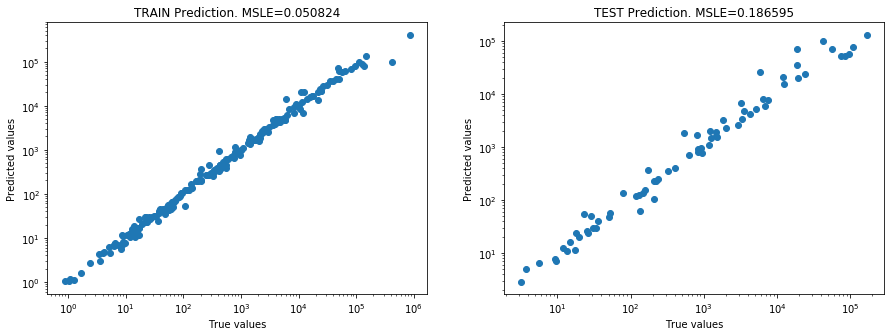

In [7]:
#Random Forests
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(criterion = 'mae', n_estimators = 7, min_samples_split = 4, min_samples_leaf = 1, max_depth = None, random_state = 42)
rf.fit(X_train, y_train)

plot_results(rf)

In [ ]:
# Grid Search CV 
from sklearn.model_selection import GridSearchCV

parameters = [{'criterion':['mse', 'mae'],
              'n_estimators':[5, 6, 7, 8, 10 ,20, 30, 40, 50, 80]}]
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = parameters, 
                           cv=5)
grid_search = grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

In [ ]:
plt.figure(figsize=(20,5))

model = rf
idx = np.argsort(y).values
vals = np.exp(model.predict(engineering(X.loc[idx])))


plt.plot(dataset[y_col][idx].values, label='true')
plt.plot(vals, label='predicted')
plt.yscale('log')
plt.legend(loc='best')

TRAIN scores. R2 score=-0.031725 MAE=13182.571795 RMSE=69858.391917 Adj R2=-0.016478
TEST scores. R2 score=-0.082652 MAE=10858.510309 RMSE=30282.889742 Adj R2=-0.202947


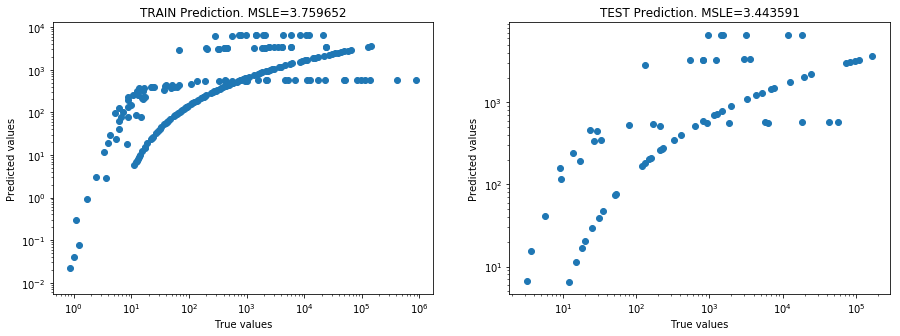

In [6]:
#Linear Regression
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)

plot_results(lin)

In [ ]:
# Grid Search CV 
from sklearn.model_selection import GridSearchCV

#parameters = [{'criterion':['mse', 'mae', 'friedman_mse'],
              'max_features':['sqrt', 'log2', 2, 3, 1, 'auto']}]
grid_search = GridSearchCV(estimator = dtr, 
                           param_grid = parameters, 
                           cv=5)
grid_search = grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

TRAIN scores. R2 score=0.882005 MAE=2545.672343 RMSE=23624.769537 Adj R2=0.883749
TEST scores. R2 score=0.935646 MAE=2893.400093 RMSE=7383.110988 Adj R2=0.928496


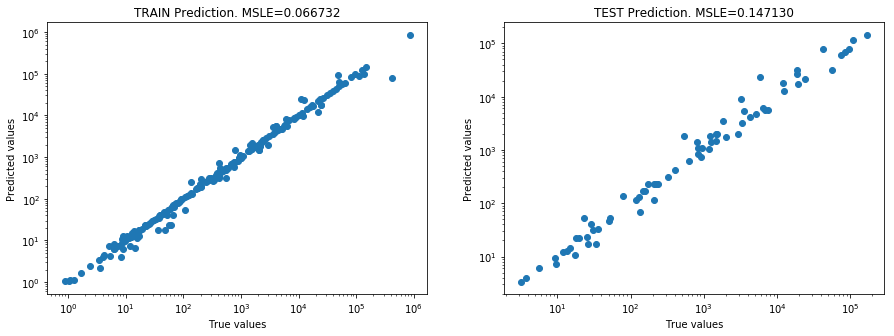

In [10]:
#Gradient Boosting Regression Trees
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
params = {'n_estimators': 500}
gb = GradientBoostingRegressor(n_estimators = 500, criterion = 'mae', loss = 'lad', learning_rate = 0.06, max_features = 'log2', subsample = 1, random_state = 42)
gb.fit(X_train, y_train)

plot_results(gb)

In [13]:
# K-fold Cross Validation
from sklearn.model_selection import cross_val_score
gb = GradientBoostingRegressor(n_estimators = 500, criterion = 'mae', loss = 'lad', learning_rate = 0.06, max_features = 'log2', subsample = 1, random_state = None)
#lin = LinearRegression()
scores = cross_val_score(gb, X_train, y_train, cv=10)

avg_score = np.mean(np.array(scores))                    
print(avg_score)
print(scores)

0.9711248359263674
[0.96818624 0.98354101 0.98426266 0.98968247 0.97807719 0.97714934
 0.94961936 0.98586196 0.9312239  0.96364424]


In [ ]:
plt.figure(figsize=(20,5))

model = gb
idx = np.argsort(y).values
vals = np.exp(model.predict(engineering(X.loc[idx])))

plt.plot(dataset[y_col][idx].values, label='true')
plt.plot(vals, label='predicted')
plt.yscale('log')
plt.legend(loc='best')

In [ ]:
# Plot feature importance
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
print(gb.feature_importances_)

In [ ]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb.staged_predict(X_test)):
    test_score[i] = gb.loss_(y_pred, y_test)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gb.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

#df = pd.DataFrame(test_score)
#test_score = df.to_excel (r'C:\Users\strahinja.markovic\Google Drive\PhD\Articles-Research Papers\Article_NMR_ML_Viscosity\Python\Deviance_nLAD\Subsampling\Subs_0.1_do_500.xlsx', header = True)

#df = pd.DataFrame(gb.train_score_)
#train_score = df.to_excel (r'C:\Users\strahinja.markovic\Google Drive\PhD\Articles-Research Papers\Article_NMR_ML_Viscosity\Python\wo_feng_Deviance_train.xlsx', header = True)

TRAIN scores. R2 score=0.999181 MAE=190.916114 RMSE=1968.338677 Adj R2=0.999193
TEST scores. R2 score=0.835472 MAE=3574.314849 RMSE=11805.177592 Adj R2=0.817191


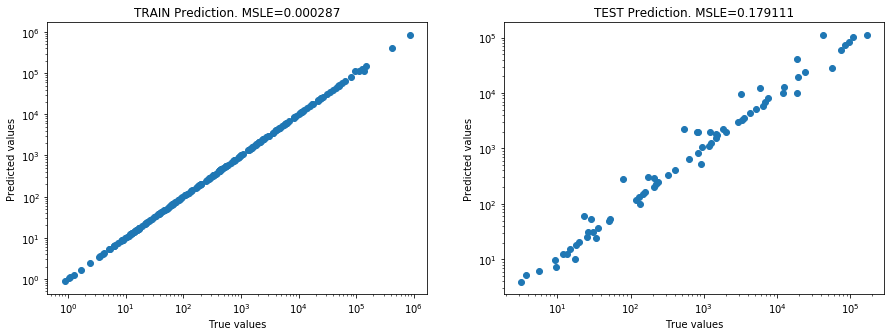

In [6]:
#k Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 6, weights = 'distance', algorithm = 'ball_tree', p = 1)
knn.fit(X_train, y_train)

plot_results(knn)

In [ ]:
# Grid Search CV 
from sklearn.model_selection import GridSearchCV

parameters = [{'n_neighbors':[1, 2, 3, 4, 6, 8, 10, 20, 50],
              'weights':['uniform','distance'], 
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'p':[1, 2],
              'metric':[]}]
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = parameters, 
                           cv=5)
grid_search = grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

In [ ]:
#Decision Trees
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor (criterion = 'mse', max_features = 1)
dtr.fit(X_train, y_train)

plot_results(dtr)

In [ ]:
# Grid Search CV 
from sklearn.model_selection import GridSearchCV

parameters = [{'criterion':['mse', 'mae', 'friedman_mse'],
              'max_features':['sqrt', 'log2', 2, 3, 1, 'auto']}]
grid_search = GridSearchCV(estimator = dtr, 
                           param_grid = parameters, 
                           cv=5)
grid_search = grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_